In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import torch
import re
from collections import namedtuple

BOARD_SHAPE = (15, 19)
%matplotlib inline
plt.ioff()

Config = namedtuple('Config', ['rows', 'cols', 'letters'])

config = Config(15, 19, 'ABCDEFGHJKLMNOP')
BOARD_SHAPE = (config.rows, config.cols)

In [2]:
# Requires 1.5
torch.__version__

'1.5.0'

# Phutball PyTorch Implementation
This notebook is to develop a (not-so-simple) function that takes as input a PyTorch tensor representing the game stat, and as output returns a tensor representing the possible next states.

State representation:
    - A tensor of shape (3, 15, 19) and dtype Boolean with the last two dimensions representing the board, and the first dimension the "channels".
    - Channel 1: Whether a player is located there
    - Channel 2: Whether the ball is located there
    - Channel 3: Whether a player located there is jumpable.
    
For simplicty, the case where the ball is off the board need not be considered. If a state can be off the board **to the right only**, a special return value should be given indicated this.

The bot will always be assumed to be playing to the **right**.

## Version 1: No implementation of Channel 3

## Utilities
Tools to construct and visualize the board states. Not meant to be performant.

In [3]:
NUM_CHANNELS = 2

In [4]:
class InvalidConfiguration(Exception):
  pass

In [5]:
def parseLocation(locStr):
  match = re.match(f'([{config.letters}])(\\d+)', locStr)
  if not match:
    raise

  row, col = match.groups()
  row = config.letters.index(row)
  col = int(col) - 1
  
  return row, col

In [6]:
def createState(ballLoc, *playerLocs):
  ballChannel   = np.zeros(BOARD_SHAPE)
  playerChannel = np.zeros(BOARD_SHAPE)
  
  for (array, locs) in [(ballChannel, [ballLoc]), (playerChannel, playerLocs)]:
    for loc in locs:
      row, col = parseLocation(loc)
      array[row][col] = 1
  return torch.tensor(np.stack([playerChannel, ballChannel]), dtype = torch.bool)

In [7]:
def visualize_state(tensor):
  plt.close() # save memory
  
  data = tensor.numpy()
  players = (data[0], 'black')
  ball    = (data[1], 'red')
  
  if (players[0] + ball[0]).max() > 1:
    raise InvalidConfiguration('Play and Ball collocated')
  elif ball[0].sum() != 1:
    raise InvalidConfiguration('Wrong number of balls')
  
  fig, ax = plt.subplots()
  ax.set_xlim([0.5  , 19.5])
  ax.set_ylim([-15.5, -0.5])
  ax.grid(True)
  ax.set_xticks(list(range(1,20)))
  ax.set_yticks(list(range(-15, 0)));
  ax.set_yticklabels('ABCDEFGHJKLMNOP'[::-1])

  for (array, color) in [players, ball]:
    for row in range(15):
      for col in range(19):
        if array[row][col]:
          ax.add_patch(plt.Circle((col+1, -(row+1)), 0.3, color=color))

  return fig

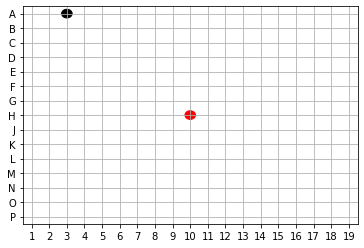

In [8]:
curr_state = createState('H10', 'A3')
visualize_state(curr_state)

## Computation of the Player Channel

In [9]:
from functools import reduce

In [10]:
# Exists in the math module in python 3.8+
def product(iterable, start = 1):
  return reduce(lambda x, y : x * y, iterable, start)

In [11]:
# Indexing goes according to the torch.flatten
#  logic, with earlier dimensions (here: row)
def get_flat_index(row, col):
  return row * config.cols + col

In [12]:
# Create an array of all possible player additions, even the illegal ones
#  Static: only has to be computed once. Performance not a concern.
placements = np.zeros(
  (product(BOARD_SHAPE), NUM_CHANNELS, *BOARD_SHAPE)
)

for row in range(config.rows):
  for col in range(config.cols):
    flat_index = get_flat_index(row, col)
    
    # Flat index is the branch for placement
    # 0 is the player channel
    placements[flat_index][0][row][col] = 1
    
placements = torch.tensor(placements, dtype = torch.bool)

In [13]:
# Given a state curr_state, select only those placements which are legal

# Consider only the ball and player layers and sum them and invert get legal positions
players = curr_state.select(0, 0) # view
ball    = curr_state.select(0, 1) # view
legal   = torch.bitwise_or(players, ball).bitwise_not_() # new tensor

legal_indices = legal.flatten().nonzero(as_tuple=True)[0]

new_placements = placements.index_select(0, legal_indices)
new_states = new_placements + curr_state

### Testing

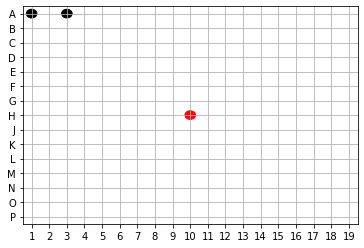

In [26]:
# First placement in upper left
visualize_state(new_states[0])

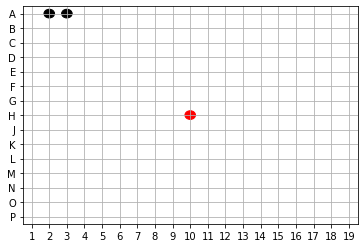

In [27]:
# Second placement moves across rows
visualize_state(new_states[1])

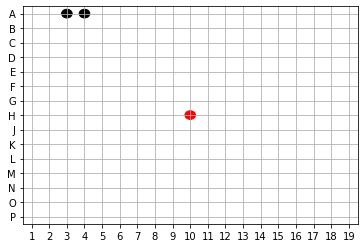

In [28]:
# Next placement skips the illegal spot
visualize_state(new_states[2])

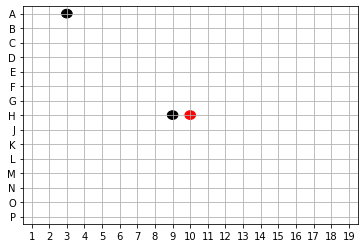

In [30]:
# Placement next to the ball
visualize_state(new_states[140])

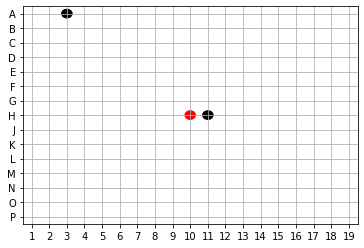

In [31]:
# Ball is skipped
visualize_state(new_states[141])